# ASL Image Prediction

This notebook loads a trained ASL Linear Classifier model and predicts the class of input images.

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Model Definition

We define the same model architecture as used in training.

In [2]:
class ASL_Linear_Classifier(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, num_classes=26):
        super(ASL_Linear_Classifier, self).__init__()
        # First Fully Connected Layer: 784 (28x28) -> 256
        self.fc1 = nn.Linear(input_size, hidden_size)
        # ReLU activation
        self.relu = nn.ReLU()
        # Dropout
        self.dropout = nn.Dropout(0.3)
        
        # Second Fully Connected Layer (Output): 256 -> 26
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Flatten: (Batch, 1, 28, 28) -> (Batch, 784)
        x = x.view(x.size(0), -1)
        
        # Forward pass
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## 2. Load Model

Load the trained model weights.

In [3]:
INPUT_SIZE = 28 * 28
HIDDEN_SIZE = 256
NUM_CLASSES = 26

model_path = Path("model/asl_linear_classifier.pt")

model = ASL_Linear_Classifier(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES).to(device)

if model_path.exists():
    checkpoint = torch.load(model_path, map_location=device)
    # Check if checkpoint is a state_dict or contains it
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    print(f"Model loaded from {model_path}")
else:
    print(f"Model file not found at {model_path}")

model.eval()  # Set to evaluation mode

Model loaded from model\asl_linear_classifier.pt


ASL_Linear_Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=26, bias=True)
)

## 3. Image Preprocessing

Define transforms to match training data (Grayscale, Resize, ToTensor).

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

def predict_image(image_path, model, device):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    # Load image
    image = Image.open(image_path)
    
    # Preprocess
    input_tensor = transform(image).unsqueeze(0).to(device) # Add batch dimension
    
    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_idx = torch.max(output, 1)
        predicted_idx = predicted_idx.item()
    
    # Map index to character
    # Assuming classes are 0-25 mapping to A-Z (skipping J and Z usually in ASL datasets, but let's assume standard A-Z mapping for now or check dataset class mapping if available. The provided code didn't explicitly show class mapping, so assuming 0=A, 1=B...)
    # Note: Sign Language MNIST usually maps 0-25 to A-Z, but J(9) and Z(25) are excluded because they involve motion. 
    # However, for simplicity, we will map 0->A, 1->B, etc.
    predicted_char = chr(ord('A') + predicted_idx)
    
    # Visualize
    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap='gray')
    plt.title(f"Prediction: {predicted_char}")
    plt.axis('off')
    plt.show()
    
    print(f"Image: {image_path} -> Predicted: {predicted_char}")

## 4. Run Prediction

Classify `a.png` and `b.png`.

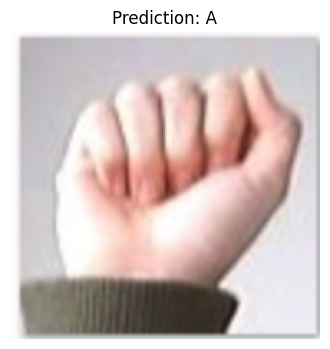

Image: data\asl_image\a.png -> Predicted: A


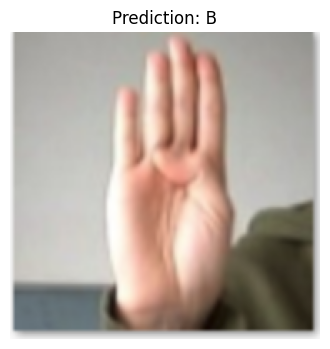

Image: data\asl_image\b.png -> Predicted: B


In [5]:
image_dir = Path("data/asl_image")
images_to_predict = ["a.png", "b.png"]

for img_name in images_to_predict:
    img_path = image_dir / img_name
    predict_image(str(img_path), model, device)